In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib as mpl

import numpy as np
import pandas as pd
import pickle as pkl

from scipy.stats import lognorm
from scipy.stats import norm

In [2]:
# Colors light to dark
cb1 = '#9dd6b3'
cb2 = '#63b3ad'
cb3 = '#4d8ca6'
cb4 = '#40639d'
cb5 = '#3f3d7a'
cb6 = '#2b1f3a'

cr1 = '#f6b48f'
cr2 = '#f37651'
cr3 = '#e13342'
cr4 = '#ad1759'
cr5 = '#701f57'
cr6 = '#35193e'

cg2 = '#acadac'

# Defaults used for ESSD paper

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=False)             #
plt.rcParams['figure.dpi'] = 100         # Display dpi
plt.rcParams['savefig.dpi'] = 300        # Save dpi
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams["axes.titlepad"] = 3.0

Necessary funtions

In [12]:
def r_trans(y):
    y = np.asarray(y)
    return np.exp(((y - a) * (obs_log_max -  obs_log_min) / (b - a)) + obs_log_min)

def reverse_transform_std(y):
    return ((y)*(obs_log_max - obs_log_min) / (b - a))

def recube(in_array):

    plev_len = 52
    lat_len = 36
    time_len = 31 * 12

    output = np.zeros([time_len, plev_len, lat_len])

    for t in range(time_len):
        output[t,:,:] = in_array[plev_len * lat_len * (t): plev_len * lat_len * (t+1)].reshape([plev_len, lat_len])
    
    return output

In [13]:
mdl_names = ['CCSRNIES',
             'WACCM',
             'CMAM',
             'CNRMr1',
             'CNRMr2',
             'EMAC47p1',
             'EMAC47p2',
             'EMAC90p1',
             'EMAC90p2',
             'GRIM',
             'IPSL',
             'MRI',
             'UMUKCA']

ppm_label = 'Ozone concentration (ppm)'
ppmu_label = 'Ozone concentration uncertainty (ppm)'

Load data

In [14]:
in_dir = './outputRAW/'
lat = pkl.load(open(in_dir + 'lats.pkl', 'rb'))
plev = np.unique(pkl.load(open(in_dir + 'plevs.pkl', 'rb'))/100)[::-1]
date = pkl.load(open(in_dir + 'dates.pkl', 'rb'))

num_models = 13
df = pd.read_pickle('./vmro3_refC1SD_70x36_13mdls_masked_extrap_and_interp.pkl')
plev_orig = np.unique(df['plev'])[::-1]
df = df[df['plev'] < 50000]
df = df[df['plev'] > 30]
obs = df['obs_toz'].copy()
obs[np.log10(obs) < -9] = np.nan
df['obs_toz'] = obs

obs = recube(df['obs_toz'].values)
train_mask = recube(df['train'].values).astype(np.bool)
test_mask = recube(df['test'].values).astype(np.bool)
interp_mask = recube(df['temp_interp'].values).astype(np.bool)
extrap_mask = recube(df['temp_extrap'].values).astype(np.bool)

obs_train = obs.copy()
obs_train[~train_mask] = np.nan
obs_test = obs.copy()
obs_test[~test_mask] = np.nan
obs_interp = obs.copy()
obs_interp[~interp_mask] = np.nan
obs_extrap = obs.copy()
obs_extrap[~extrap_mask] = np.nan

obs_min = df['obs_toz'].min()
obs_max = df['obs_toz'].max()

obs_log_max = np.log(obs_max)
obs_log_min = np.log(obs_min)
a, b = [-1, 1]

# BNN output
weights = pkl.load(open(in_dir + 'weights.pkl', 'rb'))
bias_raw = pkl.load(open(in_dir + 'bias.pkl', 'rb')) 
noise_raw = pkl.load(open(in_dir + 'noise.pkl', 'rb')) 
std_raw = recube(pkl.load(open(in_dir + 'std.pkl', 'rb')))
pred_raw = recube(pkl.load(open(in_dir + 'pred.pkl', 'rb')))
epi_raw = pkl.load(open(in_dir + 'epi.pkl', 'rb'))

train_data_count = []
for i in range(372):
    train_data_count.append(np.sum(df['train'][df['mons']==i + 1]))
train_data_count = np.array(train_data_count)


In [15]:
# Find the bounds of prediction ±1,2,3 std then convert to real values
p1plus = r_trans(pred_raw + std_raw)
p2plus = r_trans(pred_raw + 2 * std_raw)
p3plus = r_trans(pred_raw + 3 * std_raw)
p1minus = r_trans(pred_raw - std_raw)
p2minus = r_trans(pred_raw - 2 * std_raw)
p3minus = r_trans(pred_raw - 3 * std_raw)
pred = r_trans(pred_raw)

# This is also done for noise
p1plusn = r_trans(pred_raw + noise_raw)
p2plusn = r_trans(pred_raw + 2 * noise_raw)
p3plusn = r_trans(pred_raw + 3 * noise_raw)
p1minusn = r_trans(pred_raw - noise_raw)
p2minusn = r_trans(pred_raw - 2 * noise_raw)
p3minusn = r_trans(pred_raw - 3 * noise_raw)

# and epistemic uncertainty
p1pluse = r_trans(pred_raw + epi_raw)
p2pluse = r_trans(pred_raw + 2 * epi_raw)
p3pluse = r_trans(pred_raw + 3 * epi_raw)
p1minuse = r_trans(pred_raw - epi_raw)
p2minuse = r_trans(pred_raw - 2 * epi_raw)
p3minuse = r_trans(pred_raw - 3 * epi_raw)

# These values are estimates of std, noise and epi. 
# They are only estimates as the distribution is asymmetric
std1sigma = (p1plus - p1minus) / 2
std2sigma = (p2plus - p2minus) / 2
std3sigma = (p3plus - p3minus) / 2

noise1sigma = (p1plusn - p1minusn) / 2
noise2sigma = (p2plusn - p2minusn) / 2
noise3sigma = (p3plusn - p3minusn) / 2

# Epistemic uncertainty could also be found by descaling all the
# individual predictions and finding the std across them
epi1sigma = (p1pluse - p1minuse) / 2
epi2sigma = (p2pluse - p2minuse) / 2
epi3sigma = (p3pluse - p3minuse) / 2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


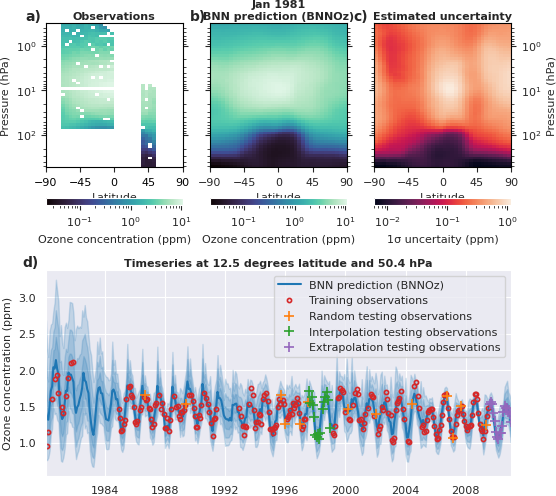

In [16]:
with plt.rc_context(dict(sns.axes_style("darkgrid"))):

    fig = plt.figure(figsize=(6,6))

    t_idx = 12
    lat_idx = 20
    plev_idx = 16
    
    vmin = np.min([pred[t_idx].min()]) * 1e6
    vmax = np.max([pred[t_idx].max()]) * 1e6

    fig.add_subplot(2, 3, 1)
    plt.pcolormesh(lat, plev, obs_train[t_idx] * 1e6, shading='nearest', cmap=sns.cm.mako, norm=colors.LogNorm(vmin=vmin, vmax=vmax), rasterized=True)
    plt.title('Observations', fontweight="heavy")
    plt.yscale('log')
    plt.xlabel('Latitude')
    plt.gca().invert_yaxis()
    plt.gca().tick_params(which="both", left=True, right=True)
    plt.gca().tick_params(which="major", bottom=True)
    plt.ylabel('Pressure (hPa)')
    plt.colorbar(orientation='horizontal', label=ppm_label)
    plt.xticks([-90, -45, 0, 45, 90], color='black')
    plt.xlim([-90, 90])
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    plt.gca().set_facecolor("white")
    plt.text(-0.15, 1.02, 'a)', transform=plt.gca().transAxes, size=10, weight='bold')
    
    fig.add_subplot(2, 3, 2)
    plt.pcolormesh(lat, plev, pred[t_idx] * 1e6, shading='nearest', cmap=sns.cm.mako, norm=colors.LogNorm(vmin=vmin, vmax=vmax), rasterized=True)
    plt.title('Jan 1981\nBNN prediction (BNNOz)', fontweight="heavy")
    plt.yscale('log')
    plt.xlabel('Latitude')
    plt.gca().invert_yaxis()
    plt.colorbar(orientation='horizontal', label=ppm_label)
    plt.gca().tick_params(which="both", left=True, right=True)
    plt.gca().tick_params(which="major", bottom=True)
    plt.xticks([-90, -45, 0, 45, 90])
    plt.gca().set_yticklabels([100])
    plt.xlim([-90, 90])
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    plt.text(-0.15, 1.02, 'b)', transform=plt.gca().transAxes, size=10, weight='bold')
    
    fig.add_subplot(2, 3, 3)
    plt.pcolormesh(lat, plev, std1sigma[t_idx] * 1e6, shading='nearest', cmap=sns.cm.rocket, norm=colors.LogNorm(), rasterized=True)
    plt.title('Estimated uncertainty', fontweight="heavy")
    plt.yscale('log')
    plt.xlabel('Latitude')
    plt.gca().invert_yaxis()
    plt.colorbar(label='1σ uncertaity (ppm)', orientation='horizontal')
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    plt.gca().set_ylabel('Pressure (hPa)')
    plt.gca().tick_params(which="both", left=True, right=True)
    plt.gca().tick_params(which="major", bottom=True) 
    plt.xticks([-90, -45, 0, 45, 90])
    plt.xlim([-90, 90])
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    plt.text(-0.15, 1.02, 'c)', transform=plt.gca().transAxes, size=10, weight='bold')

    fig.add_subplot(2, 1, 2)
    cs = sns.color_palette()

    plt.title('Timeseries at {} degrees latitude and {} hPa'.format(np.round(lat[lat_idx], 1), np.round(plev[plev_idx], 1)), fontweight="heavy")
    plt.fill_between(date, p1minus[:, plev_idx, lat_idx] * 1e6, p1plus[:, plev_idx, lat_idx] * 1e6, color=cs[0], alpha=0.2)
    plt.fill_between(date, p2minus[:, plev_idx, lat_idx] * 1e6, p2plus[:, plev_idx, lat_idx] * 1e6, color=cs[0], alpha=0.2)
    plt.fill_between(date, p3minus[:, plev_idx, lat_idx] * 1e6, p3plus[:, plev_idx, lat_idx] * 1e6, color=cs[0], alpha=0.2)
    plt.plot(date, pred[:, plev_idx, lat_idx] * 1e6, label='BNN prediction (BNNOz)', color=cs[0])
    plt.plot(date, obs_train[:, plev_idx, lat_idx] * 1e6, 'o', label='Training observations', color=cs[3], mfc=None, mew=1.2, ms=3, fillstyle='none')
    plt.plot(date, obs_test[:, plev_idx, lat_idx] * 1e6, '+', label='Random testing observations', color=cs[1], ms=7, mew=1.2)
    plt.plot(date, obs_interp[:, plev_idx, lat_idx] * 1e6, '+', label='Interpolation testing observations', color=cs[2], ms=7, mew=1.2)
    plt.plot(date, obs_extrap[:, plev_idx, lat_idx] * 1e6, '+', label='Extrapolation testing observations', color=cs[4], ms=7, mew=1.2)
    plt.ylabel('Ozone concentration (ppm)')
    plt.xlim([date[0], date[-1]])
    plt.legend()
    plt.text(-0.05, 1.02, 'd)', transform=plt.gca().transAxes, size=10, weight='bold')

plt.show()